# Demonstration of KDE-based Models

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from data_enricher.models.kde_models import *
from data_enricher.utils.kde_utils import *
from data_enricher.comparison import *


Load Data

In [2]:
# Load data as dataframe
df = pd.read_csv('data/europe.csv')
countries = df.columns.tolist()
data = torch.tensor(df.values, dtype=torch.float32)
# randomly split data into train and test
train_idx = np.random.choice(data.shape[0], int(0.8 * data.shape[0]), replace=False)
test_idx = np.setdiff1d(np.arange(data.shape[0]), train_idx)
train_data = data[train_idx]
test_data = data[test_idx]

Initialize Model

In [3]:
model = PiKernelDensityEstimator(mu=train_data)

Train Model

In [4]:
model.train(x=train_data, leave_one_out=True, modified_em=True, verbose=False)

Take Samples for Visualization

In [5]:
num_samples = train_data.shape[0]*3

samples = model.sample(num_samples=num_samples)

train_data_list = [['Training data']+x for x in train_data.tolist()]
sample_list = [['Generated data']+x for x in samples.tolist()]
pair_df = pd.DataFrame(train_data_list+sample_list,columns=['type']+countries)

pair_df_filtered = pair_df.loc[:, ['type', 'NO', 'FR', 'IT']]

Compare Samples Visually

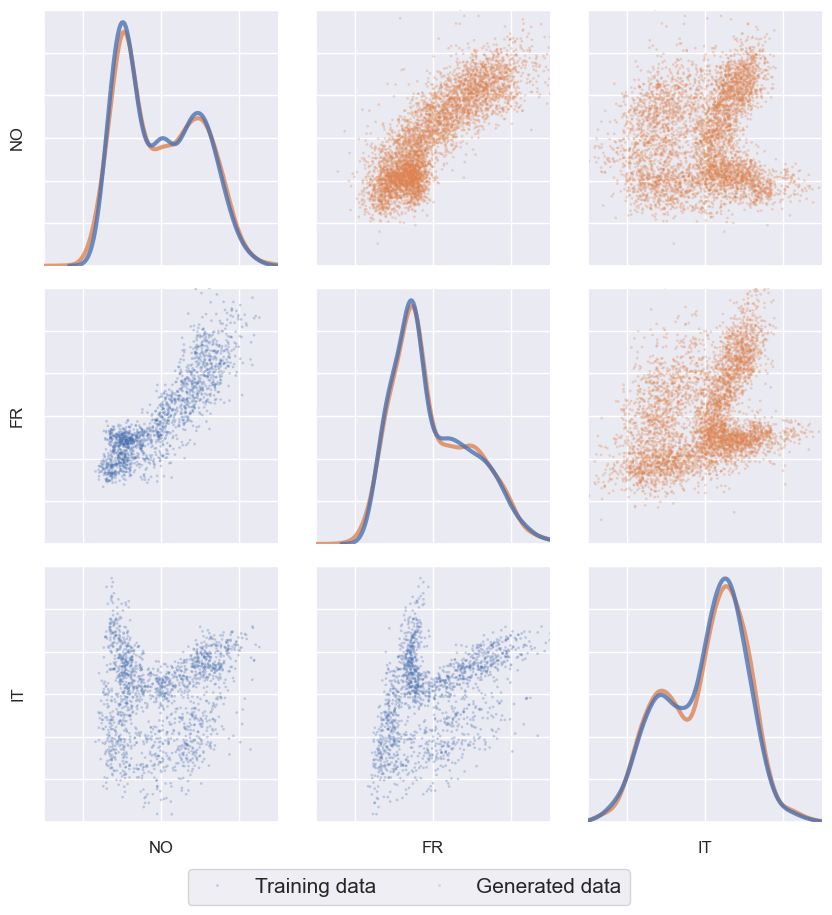

In [6]:
g = sns.PairGrid(pair_df_filtered, diag_sharey=False, hue="type", height=3, aspect=1.0)
g.map_diag(sns.kdeplot, common_norm=False, lw=3, alpha=0.8)

g.data = pair_df_filtered[pair_df_filtered['type'] != 'Generated data']
g.map_lower(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

g.data = pair_df_filtered[pair_df_filtered['type'] == 'Generated data']
g.map_upper(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

lims = 3.0
g.set(xlim=[-lims,lims], ylim=[-lims,lims])
g.set(xticklabels=[], yticklabels=[])

g.add_legend(title='', ncol=2, bbox_to_anchor=(0.525, -0.0), frameon=True, fontsize=15)
plt.show()

Inspect Kernel Badnwidths (and Weights)

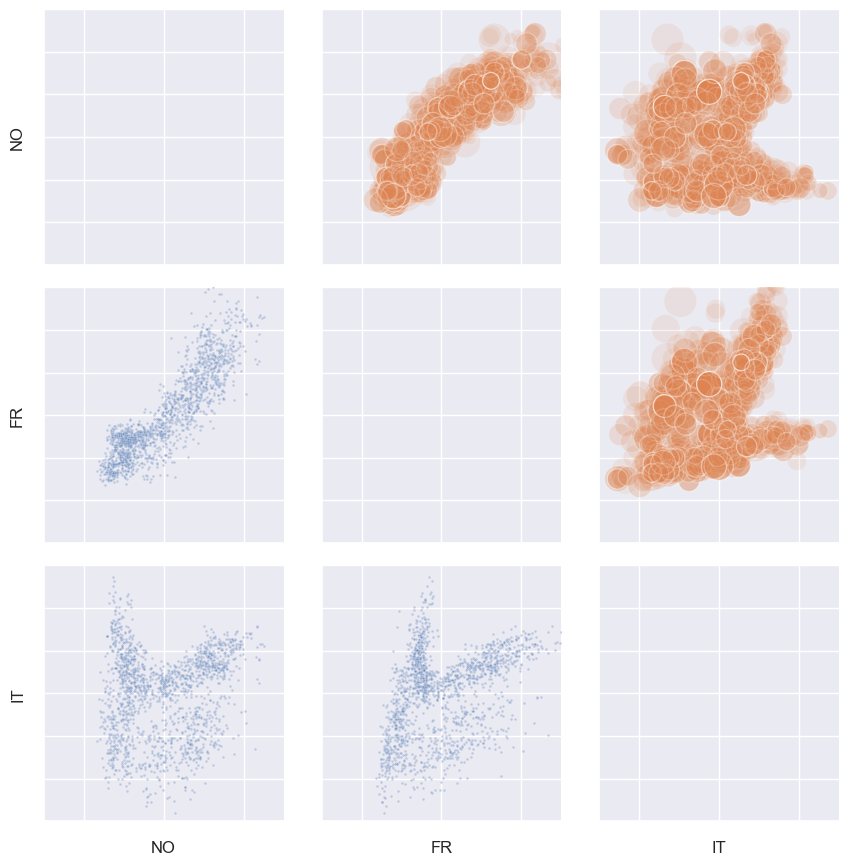

In [18]:
g = sns.PairGrid(pair_df_filtered, diag_sharey=False, height=3, aspect=1.0)

g.data = pair_df_filtered[pair_df_filtered['type'] != 'Generated data']
g.map_lower(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

g.data = pair_df_filtered[pair_df_filtered['type'] != 'Generated data']
g.map_upper(sns.scatterplot, edgecolors='face', linewidths=0.0, s=1000*to_sigma(model.sigmatilde)[0], alpha=to_pi(model.pitilde)/to_pi(model.pitilde).max())

lims = 3.0
g.set(xlim=[-lims,lims], ylim=[-lims,lims])
g.set(xticklabels=[], yticklabels=[])

plt.show()

Sample and Model Comparison Scores

In [7]:
samples = model.sample(num_samples=train_data.shape[0])
sample_test = "energy"
model_scores, base_scores = sample_comparison(model_samples=samples, train_samples=train_data, test_samples=test_data, test=sample_test, subsample_ratio=0.4, mc_runs=1000)

In [8]:
model_test = "ks"
model_score = model_comparison(model_scores=model_scores, base_scores=base_scores, test=model_test)

[]

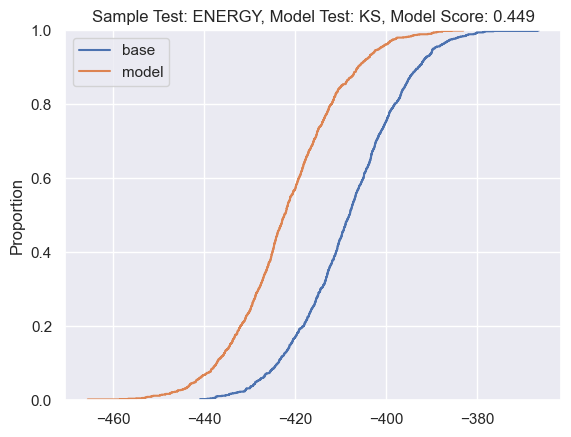

In [9]:
sns.ecdfplot(base_scores, label='base')
sns.ecdfplot(model_scores, label='model')
plt.legend()
plt.title(f"Sample Test: {sample_test.upper()}, Model Test: {model_test.upper()}, Model Score: {model_score:.3f}")
plt.plot()